# Flight Delay Project - Predictions
***
This Notebook is focused on predicting the Arrival Delay of flights. This is difference between the actual time a flight arrives at the terminal and the time it was scheduled to arrive.

The predictions will take place once the plane takes off.

I will utilise 5 different machine learning models.

Linear Regression:

- Scikit-learn's LinearRegression

Gradient Boosting:
- LightGBM's LGBMRegressor
- XGBoost's XGBRegressor
- CatBoost's CatBoostRegressor

in order to handle the large amount of categorical data in landed_df.

I will then analyse the effectiveness of the different models.

***
# Step 1: Preprocessing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
landed_df = pd.read_pickle("landed_flights.pkl")

In [3]:
landed_df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHEDULED_DEPARTURE_HOURS,SCHEDULED_DEPARTURE_MINUTES,SCHEDULED_ARRIVAL_HOUR_IN_DESTINATION_TIMEZONE,SCHEDULED_ARRIVAL_MINUTE_IN_DESTINATION_TIMEZONE
0,1,1,4,AS,98,N407AS,ANC,SEA,2015-01-01 00:05:00,2014-12-31 23:54:00,...,-22,0,0,0,0,0,0,5,4,30
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,2015-01-01 00:10:00,2015-01-01 00:02:00,...,-9,0,0,0,0,0,0,10,7,50
2,1,1,4,US,840,N171US,SFO,CLT,2015-01-01 00:20:00,2015-01-01 00:18:00,...,5,0,0,0,0,0,0,20,8,6
3,1,1,4,AA,258,N3HYAA,LAX,MIA,2015-01-01 00:20:00,2015-01-01 00:15:00,...,-9,0,0,0,0,0,0,20,8,5
4,1,1,4,AS,135,N527AS,SEA,ANC,2015-01-01 00:25:00,2015-01-01 00:24:00,...,-21,0,0,0,0,0,0,25,3,20


In [4]:
# Combine hours and minutes for Scheduled Departure.
landed_df["SCHEDULED_DEPARTURE_HOURS_MINUTES"] =\
    (landed_df["SCHEDULED_DEPARTURE_HOURS"].astype("uint16") * 60) + landed_df["SCHEDULED_DEPARTURE_MINUTES"]

# Combine hours and minutes for Scheduled Arrival.
landed_df["SCHEDULED_ARRIVAL_HOURS_MINUTES"] =\
    (landed_df["SCHEDULED_ARRIVAL"].dt.hour * 60) + landed_df["SCHEDULED_ARRIVAL"].dt.minute

# Combine hours and minutes for Scheduled Arrival in Destination Timezone.
landed_df["SCHEDULED_ARRIVAL_IN_DESTINATION_TIMEZONE_HOURS_MINUTES"] =\
    (landed_df["SCHEDULED_ARRIVAL_HOUR_IN_DESTINATION_TIMEZONE"].astype("uint16") * 60) + landed_df["SCHEDULED_ARRIVAL_MINUTE_IN_DESTINATION_TIMEZONE"]

# Drop the Hour columns, as they are replaced by the combined hour and minute columns as a record of the time of the day but keep the minute columns as categorical data.
landed_df = landed_df.drop(["SCHEDULED_DEPARTURE_HOURS","SCHEDULED_ARRIVAL_HOUR_IN_DESTINATION_TIMEZONE"], axis=1)

In [5]:
# Create a derivative feature for the Origin Airport and Airline combinations.
landed_df["OG_AIRPORT_AIRLINE"] = landed_df["ORIGIN_AIRPORT"].astype("str") + "__" + landed_df["AIRLINE"].astype("str")

# Change dtypes to category for categorical data
landed_df = landed_df.astype({"DAY_OF_WEEK":"category",
                              "MONTH":"category",
                              "DAY":"category",
                              "SCHEDULED_DEPARTURE_MINUTES":"category",
                              "SCHEDULED_ARRIVAL_MINUTE_IN_DESTINATION_TIMEZONE":"category",
                              "OG_AIRPORT_AIRLINE":"category"})

In [6]:
# Split my data into categorical and numerical columns.
cat_cols = ["AIRLINE",
            "ORIGIN_AIRPORT",
            "DESTINATION_AIRPORT",
            "DAY_OF_WEEK",
            "MONTH",
            "DAY",
            "SCHEDULED_DEPARTURE_MINUTES",
            "SCHEDULED_ARRIVAL_MINUTE_IN_DESTINATION_TIMEZONE",
            "OG_AIRPORT_AIRLINE"]

num_cols = ["DEPARTURE_DELAY",
            "TAXI_OUT",
            "DISTANCE",
            "SCHEDULED_DEPARTURE_HOURS_MINUTES",
            "SCHEDULED_ARRIVAL_HOURS_MINUTES",
            "SCHEDULED_ARRIVAL_IN_DESTINATION_TIMEZONE_HOURS_MINUTES"]

# I am transforming these 3 columns because they denote the time of day that a flight departed and I know from the Exploratory_Data_Analysis Notebook that the relationship between these columns and the Arrival Delay is non-linear.
transform_cols = ["SCHEDULED_DEPARTURE_HOURS_MINUTES",
                  "SCHEDULED_ARRIVAL_IN_DESTINATION_TIMEZONE_HOURS_MINUTES",
                  "SCHEDULED_ARRIVAL_HOURS_MINUTES"]

squared_data = landed_df[transform_cols].astype("float64") ** 2
squared_data.columns = [col + "_SQUARED" for col in transform_cols]

cubed_data = landed_df[transform_cols].astype("float64") ** 3
cubed_data.columns = [col + "_CUBED" for col in transform_cols]

# Adding the Transformed Data to landed_df.
landed_df = pd.concat([landed_df, squared_data, cubed_data], axis=1)

# Adding the transformed columns to num_cols.
transformed_cols = num_cols + squared_data.columns.to_list() + cubed_data.columns.to_list()

# Releasing memory.
squared_data, cubed_data = None, None
landed_df = landed_df.drop(["FLIGHT_NUMBER",
                            "TAIL_NUMBER",
                            "SCHEDULED_DEPARTURE",
                            "DEPARTURE_TIME",
                            "WHEELS_OFF",
                            "ELAPSED_TIME",
                            "AIR_TIME",
                            "TAXI_IN",
                            "WHEELS_ON",
                            "SCHEDULED_ARRIVAL",
                            "ARRIVAL_TIME"], axis=1)

# Creating a Dataframe for model comparison.  I will conduct a full model analysis at the end of the Notebook.
models = ["LinearRegression", "XGBoost", "LightGBM", "CatBoost"]
model_comparison = pd.DataFrame({"Model": models,
                            "Test_r2_score": 0,
                                 "Train_r2_score": 0,
                                 "Test_RMSE_score": 0,
                                 "Test_MAE_score": 0}).set_index("Model")

In [7]:
# Convert categorical features to sparse one-hot encoded format for ElasticNet
from scipy import sparse

encoder = OneHotEncoder(sparse_output=True, drop="first")
cat_sparse = encoder.fit_transform(landed_df[cat_cols])

num_data = landed_df[transformed_cols]
scaler = StandardScaler(with_mean=False) # Keeping zeros to maintain sparsity and save memory
scaled_num_data = scaler.fit_transform(num_data)

num_sparse = sparse.csr_matrix(scaled_num_data)
data_sparse = sparse.hstack([cat_sparse, num_sparse])

***
# Step 2: Machine Learning

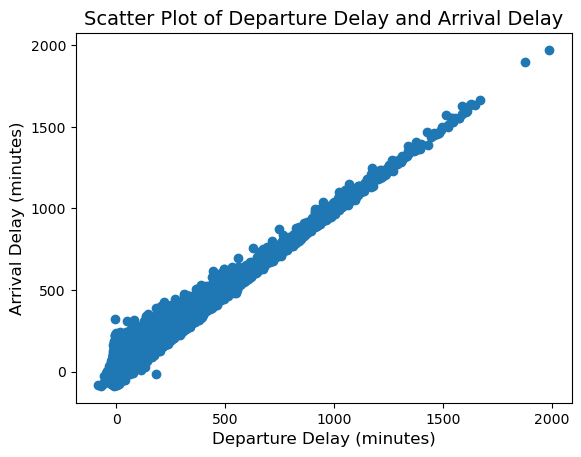

In [8]:
plt.scatter(landed_df["DEPARTURE_DELAY"], landed_df["ARRIVAL_DELAY"])
plt.title("Scatter Plot of Departure Delay and Arrival Delay", size=14)
plt.xlabel("Departure Delay (minutes)", size=12)
plt.ylabel("Arrival Delay (minutes)", size=12)
plt.show()

***
# Scikit-learn's LinearRegression

### Why I am using Linear Regression
Linear regression assumes that the relationship between the features and the target variable are linear.

The reason why I am using linear regression as my first model is because of the positive linear correlation between Departure Delay and Arrival Delay that I discovered in my EDA.  This linear relationship is also obvious because Departure Delay is an embedded feature of Arrival Delay.

From my EDA, it does not appear that any features are multicollinear which also makes linear regression a good choice.  However, if there are complicated relationships between the categorical features, which I suspect that there is, the model will be unable to pick up on this.  Even so, LinearRegression is a good baseline to use to compare to other models.

LinearRegression uses OLS.  If the model overfits, we can use a different cost function that incorporates regularisation.


### How Scikit-learn's LinearRegression works

Linear Regression multiplies each feature (x) by a constant weight (w).

The sum of all of these wx (feature multiplied by constant) is the predicted Arrival Delay.  The weights can be positive or negative.  Positive weights mean that when the feature increases the predicted Arrival Delay also increases and negative weights mean that when the feature decreases, the predicted Arrival Delay increases.  If a feature's weight is closer to 0, it means that it has a negligible effect on the Arrival Delay.

Linear Regression uses a loss function of SSE.  This is the sum of the squared difference between the predicted Arrival Delay and the actual Arrival Delay.

Scikit-Learn's LinearRegression function does not use gradient descent and calculates the optimal weights without iteration.  It also doesn't use the normal equation:

$X^TXθ=X^Ty$

where $X$ is the train dataset, $θ$ is the vector of weights to find and $y$ is the actual Arrival Delay. The normal equation is found by setting the gradient of the loss function to 0 (and then rearranging).  The problem is that the model has to find $X^TX$ and $X$ is huge and so the matrix multiplication is very computationally expensive.

This means that Scikit-learn's LinearRegression uses QR Decomposition which is less computationally expensive.  This calculates $Q$ and $R$ where $QR = X$.  $Q$ has the same shape as $X$, but it has orthonormal columns, which means that $Q^TQ = I$.  This means that we do not need to calculate $Q^T * Q$ as the 2 matrices create an identity matrix.  $R$ is an upper triangle matrix of size $n x n$ where $n$ is the number of features.

By using $X = QR$, we can change the normal equation$Rθ = Q^Ty$  Because $Q^Ty$ is a vector with as many values as there are features, $R$ is an upper triangle matrix of size $n * n$ where $n$ is the number of features, and $θ$ is just a vector of the weights, the model can engage in back-substitution to quickly find the optimal weights.

In [9]:
from sklearn.linear_model import LinearRegression

# Splitting the data.
train_sparse_data, test_sparse_data, train_result, test_result = train_test_split(data_sparse, landed_df["ARRIVAL_DELAY"], test_size=0.5, random_state=42)

# Defining the model.
linear =  LinearRegression()
linear.fit(train_sparse_data, train_result)

# Testing the model.
linear_test_prediction = linear.predict(test_sparse_data)
linear_train_prediction = linear.predict(train_sparse_data)

# Recording the accuracy of the model.
test_r2_score = r2_score(test_result, linear_test_prediction)
train_r2_score = r2_score(train_result, linear_train_prediction)
test_rmse_score = mean_squared_error(test_result, linear_test_prediction, squared=False)
test_mae_score = mean_absolute_error(test_result, linear_test_prediction)
model_comparison.loc["LinearRegression"] = [test_r2_score, train_r2_score, test_rmse_score, test_mae_score]

print(f"Test r2 Score:   {test_r2_score:.4f}")
print(f"Train r2 Score:  {train_r2_score:.4f}")
print(f"Test RMSE score: {test_rmse_score:.4f}")
print(f"Test MAE Score:  {test_mae_score:.4f}")

Test r2 Score:   0.9391
Train r2 Score:  0.9394
Test RMSE score: 9.6821
Test MAE Score:  6.8535


The very similar test (0.9391) and train (0.9394) r2 scores show that the model doesn't have a significant problem with overfitting.

The 0.9391 r2 score is notably higher than the r2 correlation, from my EDA, between Departure Delay and Arrival Delay of 0.88 which shows that the a

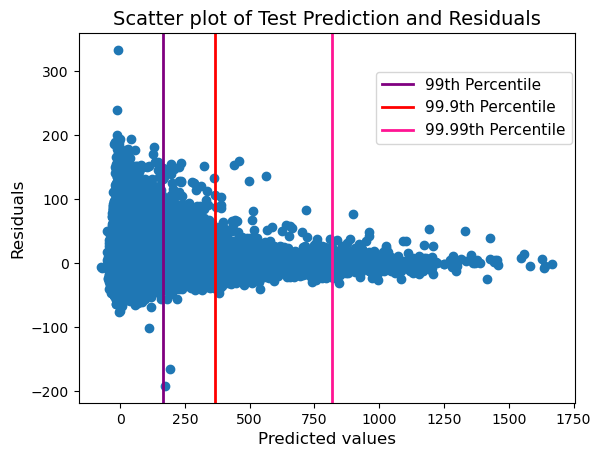

In [10]:
linear_residuals = test_result - linear_test_prediction

plt.scatter(linear_test_prediction, linear_residuals)

plt.axvline(np.percentile(linear_test_prediction, 99), color="purple", linewidth=2, label="99th Percentile")
plt.axvline(np.quantile(linear_test_prediction, 0.999), color="red", linewidth=2, label="99.9th Percentile")
plt.axvline(np.quantile(linear_test_prediction, 0.9999), color="deeppink", linewidth=2, label="99.99th Percentile")

plt.title("Scatter plot of Test Prediction and Residuals", size=14)
plt.xlabel("Predicted values", size=12)
plt.ylabel("Residuals", size=12)
plt.legend(fontsize=11, loc=(0.6, 0.7))

plt.show()

The scatter plot is not effective for assessing whether the variation of the residual values are homoscedastic because, we know from our EDA, that the Predicted Values are skewed to the left, as we can see by the percentile lines.

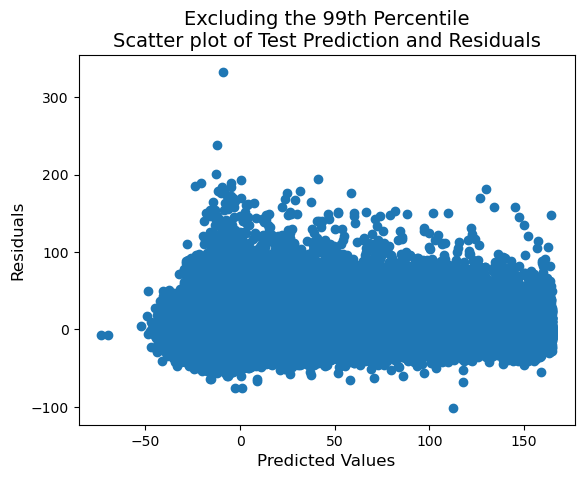

In [11]:
plt.scatter(linear_test_prediction[linear_test_prediction<np.percentile(linear_test_prediction, 99)],
            linear_residuals[linear_test_prediction<np.percentile(linear_test_prediction, 99)])

plt.title("Excluding the 99th Percentile\nScatter plot of Test Prediction and Residuals", size=14)
plt.xlabel("Predicted Values", size=12)
plt.ylabel("Residuals", size=12)

plt.show()

When we exclude the 99th percentile, we can see that there doesn't appear to be a large variation in the residual values.

Whilst there is a larger range of Residuals around 0, we know from the EDA, that we would expect the majority of values to be around 0 as well.  If anything, the similar range of Residuals throughout the positive Predicted Values indicates that as the Predicted Values increase, so does the variation of Residuals.

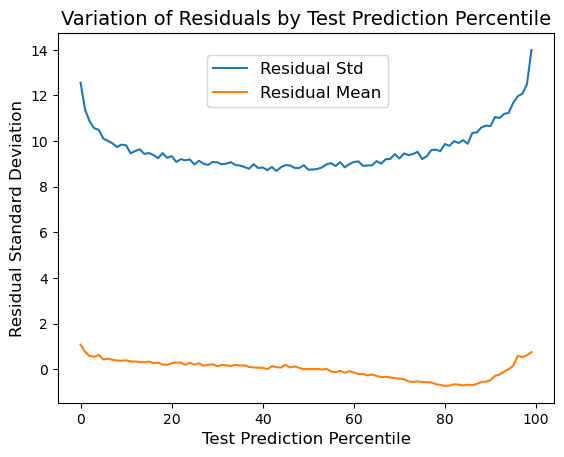

In [12]:
linear_df = pd.DataFrame({"prediction": linear_test_prediction,
                   "residual": linear_residuals})

linear_df["percentile"] = pd.qcut(linear_df["prediction"], q=100, labels=False)

grouped_linear_df = linear_df.groupby("percentile")["residual"].agg(["mean", "std"])

plt.plot(grouped_linear_df.index, grouped_linear_df["std"], label="Residual Std")
plt.plot(grouped_linear_df.index, grouped_linear_df["mean"], label="Residual Mean")

plt.title("Variation of Residuals by Test Prediction Percentile", size=14)
plt.xlabel("Test Prediction Percentile", size=12)
plt.ylabel("Residual Standard Deviation", size=12)
plt.legend(fontsize=12, loc=(0.3,0.8))
plt.show()

By plotting the standard deviation and mean for each percentile we can better evaluate whether the residuals are homoscedastic.

The residuals are fairly heteroscedastic instead, which means that the prediction errors in the model vary significantly depending on the predicted value, and in this case vary more when the test predictions are very small or very large.  Because the residuals are heteroscedastic, we can't make statistical inferences about the model based on the standard error of the weights, or conduct significance tests on the weights to test whether they are statistically significant.

The mean also varies, showing that the model has a systematic bias: it overpredicts very small and underpredicts very large predicted values.  It also underpredicts predicted values that are quite large.

In [13]:
# Recovering the feature names from OneHotEncoder
cat_features = encoder.get_feature_names_out(cat_cols)

# Feature Importance.
pd.DataFrame({"Feature": list(cat_features) + transformed_cols,
              "Weight": linear.coef_,
              "Abs_Weight":np.abs(linear.coef_)})\
    .set_index("Feature")\
    .nlargest(50, 'Abs_Weight')

,Weight,Abs_Weight
Feature,,
DEPARTURE_DELAY,36.773139,36.773139
OG_AIRPORT_AIRLINE_MSY__MQ,-15.262474,15.262474
OG_AIRPORT_AIRLINE_JFK__HA,15.224270,15.224270
ORIGIN_AIRPORT_LGA,-14.497642,14.497642
OG_AIRPORT_AIRLINE_CHS__AS,-14.272149,14.272149
OG_AIRPORT_AIRLINE_IAD__AS,-12.267342,12.267342
OG_AIRPORT_AIRLINE_GSO__AA,-11.343854,11.343854
ORIGIN_AIRPORT_JFK,-10.760506,10.760506
DESTINATION_AIRPORT_CDC,10.420193,10.420193


Despite not being able to make statistical inferences from the feature weights, we can still conduct feature importance analysis based on the weight magnitude.

Departure Delay is the most important feature.

Many airport airline combinations are part of the most important features.  This is expected as they make up the majority of the features (when they are one-hot-encoded).

Hawaiian is the only airline included in the top 50 most important features.  I suspect that this is because there are more flights per airline than flights per airport-airline combination causing there to be less variation for each airline feature.

The effectiveness of the airport-airline derivative feature right at the top of the Dataframe.  JFK as an Origin Airport has a weight of -11 but the JFK-Hawaiian combination has a weight of +8.  This feature allows the model to understand the complex relationships between Airlines and Airports

***
# XGBRegressor Gradient Boost

I am using Gradient Boosting because, through its decision trees, it can capture complex non-linear relationships that I believe are present in the data, and that linear regression is unable to learn from.  In particular, relationships between the categorical features of the data.  As an example, if flights leaving JFK in the morning having a larger arrival delay than in the evening, this would be the opposite of the pattern seen in my EDA.  A Gradient Boosting model, would be able to spot this interaction which a Linear Regression model would miss.

I am using 3 different Gradient Boosting ML models.  In a situation

### Creating the Decision Trees
The model first creates an initial prediction by predicting the mean probability of result_train (~0.53) for every single row. It does this by putting the log-odds of result_train and putting that into a sigmoid function. The model will be calculating log-odds

The model then finds the residuals (the difference between the predicted probability and the actual result) of each row. The residual is also called the gradient.

Then, the model selects a random subset of features (determined by colsample_by_tree), and evaluates every possible way to split the features and selects the split that best maximises the gain function.  To do this the split will:

- Maximises the square of the sum of residual values (to group together rows with similar errors).
- And minimises the sum of Hessian values (to prioritise correcting rows where the model is confidently incorrect).

This gives more weight to predicted probabilities that are very wrong. It increases the number of nodes (from 1 to 2).

The process repeats itself on each of the new nodes, splitting them as well, and continues to repeat until:

- The "max_depth" (number of successive splits) is reached.
- The sum of hessian values (of rows) at a node is less than "min_child_weight".
### Calculating the Probability
Once the tree has finished splitting the data, the model goes through each individual leaf and calculates for each row in that leaf a new probability.

It first calculates:

- The Hessian value: probability * (1 - probability)
- The log-odds: log( probability / (1 - probability) )

Calculate Delta/Leaf Score:

- All of the residual values in the leaf are added together.
- All of the hessian values in the leaf are added together.
- The sum of the residuals is then divided by: the sum of the hessians + L2 regularisation constant. The L2 regularisation constant is determined by "reg_lambda".
- This value is then multiplied by -1 (in order to minimise, rather than maximise, the loss function). This value is Delta, and it is stored in the leaf as the Leaf Score.

Calculate updated probability for each individual row:

- Delta is then multiplied by the "learning_rate".
- This is added to the log-odds for each individual row. (Each row has its own log-odds but the delta is shared by all rows in that leaf.)
- Then the new probability is calculated by putting the log-dds in the sigmoid function.
- Finally, the new residual value is calculated by finding the difference between the new probability and the actual result.

Then, the model takes the new residual values and moves onto the next tree. The number of trees is determined by "n_estimators".

Predicting the result
Each row is put through the first tree and follows the decision nodes until it makes it to a leaf. Once it is at a leaf, the Leaf Score of that leaf is added to the row's log-odds (which starts at 0).

Then each row moves on to the next tree and gets a Leaf Score added to its log-odds, and then the next tree and Leaf Score, and so on. When each row has passed through every single tree, the log-odds of each row is converted to probability through the sigmoid function. If the output of the sigmoid function is above 0.5 the model predicts, for that row, that the Blue team will win, if not, it predicts that the red team will win.

### My HyperParameters

I will explain some of my hyperparameters that I haven't touched on so far.

**tree_method="hist"**

This enables binning.  Binning is done natively by LGBMRegressor, which is the next Gradient Boosting model I will use, but by setting tree_method to "hist" XGBRegressor can engage in Binning too.
- This puts both categorical and numerical features into bins which reduces the number of split points needed to be evaluated at each node.
- The Hessians and Gradients are calculated for all the values in each bin and so when a split point is evaluated the model doesn't need to add up the 5 million values again but just the 256 sums of the Hessians and Gradients for each bin.
- Bins are re-calculated at each individual node based off of the flights in that node.

**enable_categorical=True**

This allows the model to accept categorical data without one-hot encoding.

**n_jobs=-1**

This allows the model to use the maximum amount of computing power.

**min_child_weight=500**

This stops nodes from splitting and creating a leaf that would have less than 500 flights.  This helps to stop overfitting.  I have chosen a large number of 500 because my dataset is very large and my test size is over 2.5 million.

**n_estimators and max_depth**

I have chosen a relatively low list of potential n_estimators and a high list for max_depth.  This is because I think there will be many complicated interactions between the features (such as flights of a particular airport at a particular time, at a particular time of year, on a particular airline).  By having a large max_depth it increases the chances that the model can find and learn from these interactions.  The low n_estimators is in order to counteract the high max_depth and prevent overfitting.

In [14]:
from xgboost import XGBRegressor

# Splitting the data.  The 3 Gradient Boost algorithms I am using process categorical features natively (without the need to do one-hot encoding).
# I am also not using the transformed columns (as I am for LinearRegression).
train_data, test_data, train_result, test_result = train_test_split(landed_df[cat_cols + num_cols], landed_df["ARRIVAL_DELAY"], test_size=0.5, random_state=42)

# Defining my model, the param grid and the grid search.
xgb = XGBRegressor(tree_method="hist",
                    enable_categorical=True,
                    reg_alpha=1.5,
                    reg_lambda=1.5,
                    colsample_bytree=0.5,
                    n_jobs=-1)

param_grid = {"n_estimators": [60, 80, 100, 120],
              "max_depth": [40, 50, 60],
              "min_child_weight":[500, 750, 1000],
              "learning_rate": [0.1, 0.2, 0.3]}

grid_search = GridSearchCV(xgb,
                           param_grid,
                           cv=2,
                           n_jobs=-1)

grid_search.fit(train_data, train_result)
best_xgb = grid_search.best_estimator_

# Testing the model.
xgb_test_prediction = best_xgb.predict(test_data)
xgb_train_prediction = best_xgb.predict(train_data)

# Recording the accuracy of the model.
test_r2_score = r2_score(test_result, xgb_test_prediction)
train_r2_score = r2_score(train_result, xgb_train_prediction)
test_rmse_score = mean_squared_error(test_result, xgb_test_prediction, squared=False)
test_mae_score = mean_absolute_error(test_result, xgb_test_prediction)
model_comparison.loc["XGBoost"] = [test_r2_score, train_r2_score, test_rmse_score, test_mae_score]

print(f"Test r2 Score:   {test_r2_score:.4f}")
print(f"Train r2 Score:  {train_r2_score:.4f}")
print(f"Test RMSE score: {test_rmse_score:.4f}")
print(f"Test MAE Score:  {test_mae_score:.4f}")
print(grid_search.best_params_)

Test r2 Score:   0.9004
Train r2 Score:  0.9224
Test RMSE score: 12.3884
Test MAE Score:  6.3029
{'learning_rate': 0.2, 'max_depth': 40, 'min_child_weight': 500, 'n_estimators': 120}


I used the parameters:
- reg_alpha=1.5,
- reg_lambda=1.5,
- colsample_bytree=0.5

In order to help reduce overfitting, which was a significant problem with using XBGRegressor on this dataset.

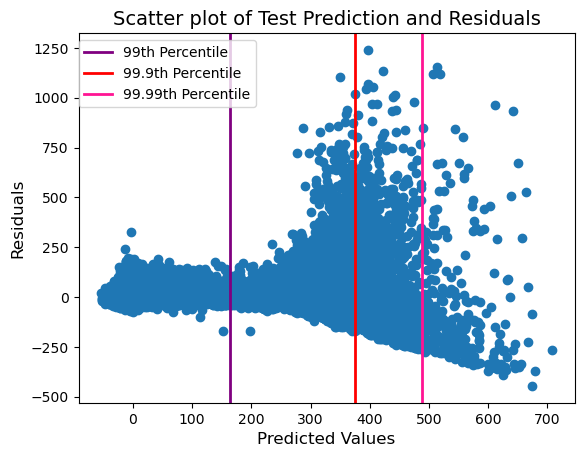

In [16]:
xgb_residuals = test_result - xgb_test_prediction

plt.scatter(xgb_test_prediction, xgb_residuals)
plt.axvline(np.percentile(xgb_test_prediction, 99), color="purple", linewidth=2, label="99th Percentile")
plt.axvline(np.quantile(xgb_test_prediction, 0.999), color="red", linewidth=2, label="99.9th Percentile")
plt.axvline(np.quantile(xgb_test_prediction, 0.9999), color="deeppink", linewidth=2, label="99.99th Percentile")

plt.title("Scatter plot of Test Prediction and Residuals", size=14)
plt.xlabel("Predicted Values", size=12)
plt.ylabel("Residuals", size=12)
plt.legend(fontsize=10, loc=(0, 0.8))

plt.show()

This extreme variation in the 99th percentile is not present for LinearRegression.  I believe that this is because XGBoost bins numerical features and so because there are only a few samples with a very large Departure Delay, the splits for the bins can't be very precise which causes greater error variance.

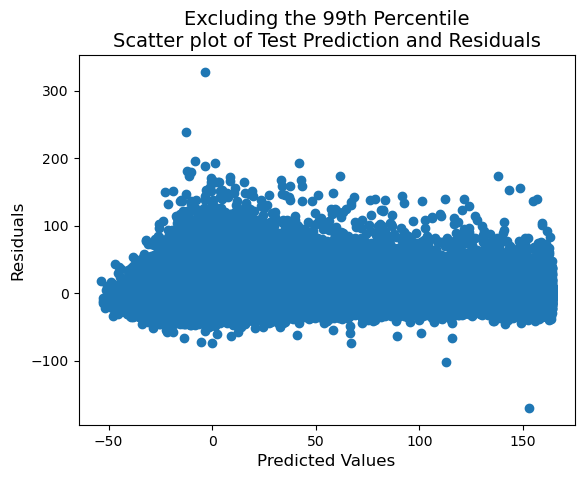

In [17]:
plt.scatter(xgb_test_prediction[xgb_test_prediction<np.percentile(xgb_test_prediction, 99)], xgb_residuals[xgb_test_prediction<np.percentile(xgb_test_prediction, 99)])

plt.title("Excluding the 99th Percentile\nScatter plot of Test Prediction and Residuals", size=14)
plt.xlabel("Predicted Values", size=12)
plt.ylabel("Residuals", size=12)

plt.show()

The shape of this scatter plot is remarkably similar to that of LinearRegression, and the same analysis for the LinearRegression model applies to the XGBoost model as well.

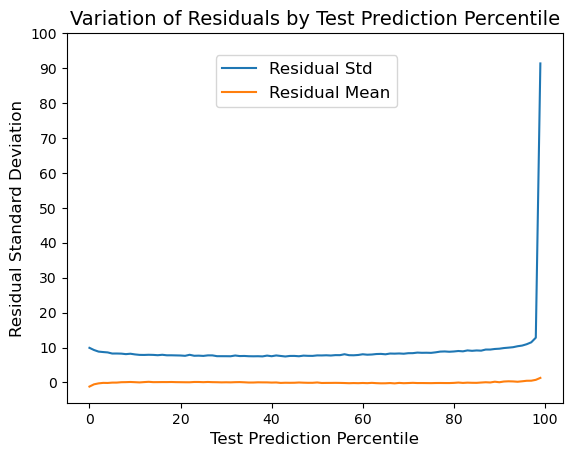

In [18]:
xgb_df = pd.DataFrame({"prediction": xgb_test_prediction,
                        "residual": xgb_residuals})

xgb_df["percentile"] = pd.qcut(xgb_df["prediction"], q=100, labels=False)

grouped_xgb_df = xgb_df.groupby("percentile")["residual"].agg(["mean", "std"])

plt.plot(grouped_xgb_df.index, grouped_xgb_df["std"], label="Residual Std")
plt.plot(grouped_xgb_df.index, grouped_xgb_df["mean"], label="Residual Mean")

plt.title("Variation of Residuals by Test Prediction Percentile", size=14)
plt.xlabel("Test Prediction Percentile", size=12)
plt.ylabel("Residual Standard Deviation", size=12)
plt.yticks(range(0,101,10))
plt.legend(fontsize=12, loc=(0.3,0.8))

plt.show()

The extreme variation in the 99th Percentile, is also clearly present when we look at the Residual Standard Deviation by Percentile.  It appears to perform slightly better than LinearRegression for all other percentiles, indicating that its poor r2 score stems from its poor predictions for very large values.

In [19]:
# Feature Importance.
xgb_importance_df = (pd.DataFrame({"Gain Importance": best_xgb.get_booster().get_score(importance_type="total_gain"),
                                   "Split Importance": best_xgb.get_booster().get_score(importance_type="weight")},
                                  index=cat_cols + num_cols)
                      .sort_values(by="Gain Importance", ascending=False))

xgb_importance_df/xgb_importance_df.sum()

,Gain Importance,Split Importance
DEPARTURE_DELAY,0.851507,0.048929
TAXI_OUT,0.049949,0.052268
AIRLINE,0.014365,0.044711
MONTH,0.011675,0.062824
DAY,0.010728,0.075774
SCHEDULED_DEPARTURE_HOURS_MINUTES,0.009132,0.093700
DISTANCE,0.007777,0.131797
OG_AIRPORT_AIRLINE,0.007684,0.016308
ORIGIN_AIRPORT,0.007094,0.033885
SCHEDULED_ARRIVAL_IN_DESTINATION_TIMEZONE_HOURS_MINUTES,0.006860,0.097674


Departure Delay, as expected is the most important feature followed by Taxi Out.

Airline is the most important categorical feature.

The features dealing with time are split on a huge proportion of the time.  The Origin Airport-Airline combination feature is split on less than 2% of the time

***
# LGBMRegressor Gradient Boost

LGBMRegressor is similar to XGBRegressor and has the same Gain function (to decide how to split each node), but it works differently and should be more suitable for this project.

It has a fast time to compute and is optimised to better deal with large numbers of categorical features than XGBoost.  The primary reason why I suspect that it will explain more of the variance of Arrival Delay is because of its leaf-wise growth which will allow the model to better understand the complicated relationships between the categorical features.

**Leaf-wise Growth**
- Leaf-wise Tree growth is different to XGBRegressor, which splits every leaf on each level before moving onto the next one.
- LGBMRegressor does not split every single leaf on a level before moving onto the next leaf and will evaluate every single leaf (on all levels) to decide which is the best split.  This means that it makes fewer low-Gain splits because it prioritises the leaves that maximise the Gain function and will reach the maximum number of leaves (num_leaves) it enacts fewer low-Gain splits.
- I believe that this will allow the model to understand and utilise the relationships between the categorical variables, such as a particular airline at a particular airport at a particular time of the year.

**Binning Strategy**
- Like XGBoost when using tree_method="hist", LGBMRegressor sorts the categories by the size of their Gradient to Hessian ratio in order to find categories that are most similar to each other to bin together.  However LGBMRegressor is better optimised for this.

LGBMRegressor is, in general, just better at handling large amounts of categorical data than XBGRegressor.

### Parameters

I am using large values for "num_leaves" in order to increase the chances of the model finding complicated interactions between features in the data.  In my preliminary run of the model, I did not have any significant problems with overfitting, and so I have not needed to use parameters such as max_depth, min_data_in_leaf, feature_fraction, lambda_l1, or lambda_l2.  However, I have set min_data_in_leaf to its default value.

In [20]:
from lightgbm import LGBMRegressor

# Defining my model, the param grid and the grid search.
lgbm = LGBMRegressor(objective="regression",
                     random_state=42,
                     verbose=-1,
                     min_data_in_leaf=20)

param_grid = {"n_estimators": [150, 250, 350],
              "num_leaves": [200, 250, 300, 350],
              "learning_rate": [0.1, 0.2, 0.4, 0.8]}

grid_search = GridSearchCV(lgbm,
                           param_grid,
                           cv=3,
                           n_jobs=-1)

grid_search.fit(train_data, train_result)
best_lgbm = grid_search.best_estimator_

# Testing the model.
lgbm_test_prediction = best_lgbm.predict(test_data)
lgbm_train_prediction = best_lgbm.predict(train_data)

# Recording the accuracy of the model.
test_r2_score = r2_score(test_result, lgbm_test_prediction)
train_r2_score = r2_score(train_result, lgbm_train_prediction)
test_rmse_score = mean_squared_error(test_result, lgbm_test_prediction, squared=False)
test_mae_score = mean_absolute_error(test_result, lgbm_test_prediction)
model_comparison.loc["LightGBM"] = [test_r2_score, train_r2_score, test_rmse_score, test_mae_score]

print(f"Test r2 Score:   {test_r2_score:.4f}")
print(f"Train r2 Score:  {train_r2_score:.4f}")
print(f"Test RMSE score: {test_rmse_score:.4f}")
print(f"Test MAE Score:  {test_mae_score:.4f}")
print(grid_search.best_params_)

Test r2 Score:   0.9543
Train r2 Score:  0.9717
Test RMSE score: 8.3919
Test MAE Score:  5.6911
{'learning_rate': 0.2, 'n_estimators': 350, 'num_leaves': 350}


The Test r2 score of (0.9543) is notably higher than for XGBoost (0.9004) and for LinearRegression (0.9391), however it is below the train score (0.9717) and so the model is overfitting.

If the test data was from a subsequent year, there would be more overfitting, because many of the complex relationships between features in 2016 could just be noise.

In [22]:
lgbm_residuals = test_result - lgbm_test_prediction

print(f"LGBMRegressor residual standard deviation: {lgbm_residuals.std():.4f}")
print(f"LinearRegression residual standard deviation: {linear_residuals.std():.4f}")

LGBMRegressor residual standard deviation: 8.3919
LinearRegression residual standard deviation: 9.6821


The better r2 score for LightGBM is supported by the lower standard deviation of its residuals.

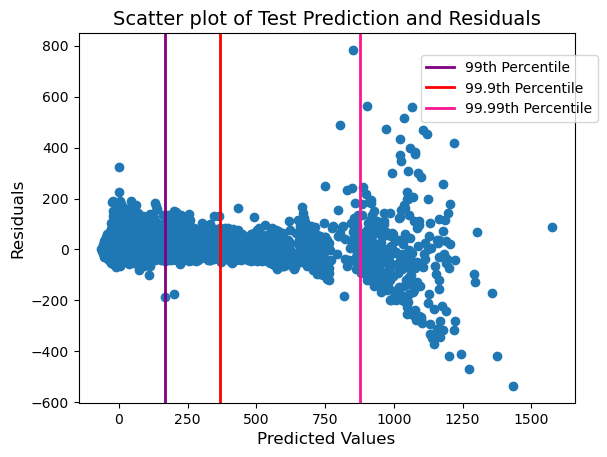

In [23]:
plt.scatter(lgbm_test_prediction, lgbm_residuals)
plt.axvline(np.percentile(lgbm_test_prediction, 99), color="purple", linewidth=2, label="99th Percentile")
plt.axvline(np.quantile(lgbm_test_prediction, 0.999), color="red", linewidth=2, label="99.9th Percentile")
plt.axvline(np.quantile(lgbm_test_prediction, 0.9999), color="deeppink", linewidth=2, label="99.99th Percentile")

plt.title("Scatter plot of Test Prediction and Residuals", size=14)
plt.xlabel("Predicted Values", size=12)
plt.ylabel("Residuals", size=12)
plt.legend(fontsize=10, loc=(0.69, 0.76))

plt.show()

For large Predicted Values, above 750, the variation in Residuals increases significantly and so the model is less reliable for very large Predicted Values.

There is notably less extreme variation throughout the 99th percentile than in XGBoost

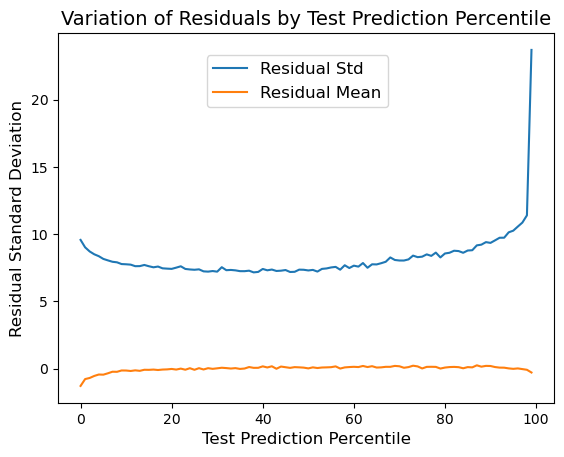

In [24]:
lgbm_df = pd.DataFrame({"prediction": lgbm_test_prediction,
                        "residual": lgbm_residuals})

lgbm_df["percentile"] = pd.qcut(lgbm_df["prediction"], q=100, labels=False)

grouped_lgbm_df = lgbm_df.groupby("percentile")["residual"].agg(["mean", "std"])

plt.plot(grouped_lgbm_df.index, grouped_lgbm_df["std"], label="Residual Std")
plt.plot(grouped_lgbm_df.index, grouped_lgbm_df["mean"], label="Residual Mean")

plt.title("Variation of Residuals by Test Prediction Percentile", size=14)
plt.xlabel("Test Prediction Percentile", size=12)
plt.ylabel("Residual Standard Deviation", size=12)
plt.legend(fontsize=12, loc=(0.3,0.8))

plt.show()

There is fairly good stability among the standard deviation of Residuals but the model is worse for very small Predicted Values, and significantly worse for very large Predicted Values.

The model is also largely unbiased in its predictions, only overpredicting the lowest percentiles.

Whilst the model is heteroscedastic, it is only just so, and if you were to exclude the residuals in the 99.99th percentile, the model could be considered somewhat homoscedastic.

In [25]:
# Feature Importance.
lgbm_importance_df = (pd.DataFrame({"Gain Importance": best_lgbm.booster_.feature_importance(importance_type='gain'),
                                   "Split Importance": best_lgbm.booster_.feature_importance(importance_type='split')},
                                  index=cat_cols + num_cols)
                      .sort_values(by="Gain Importance", ascending=False))

lgbm_importance_df/lgbm_importance_df.sum()

,Gain Importance,Split Importance
DEPARTURE_DELAY,0.916425,0.057192
TAXI_OUT,0.035470,0.038993
OG_AIRPORT_AIRLINE,0.017218,0.224077
DESTINATION_AIRPORT,0.006430,0.111175
ORIGIN_AIRPORT,0.005724,0.036422
DAY,0.003919,0.134261
SCHEDULED_ARRIVAL_MINUTE_IN_DESTINATION_TIMEZONE,0.003040,0.137994
DISTANCE,0.002655,0.042996
MONTH,0.002632,0.058019
AIRLINE,0.001635,0.003488


LGBMRegressor is prioritising Departure Delay more than XGBRegressor, and the predictive capabilities of the model are mainly driven by Departure Delay (which is an embedded feature).

However, the majority of its splits are on the categorical features such as Origin Airport-Airline combination and the Day of the month.

Airline is not a very important feature and this may be because the information it captures is also present in the Origin Airport-Airline combination feature.

***
# CatBoostRegressor Gradient Boost

I am using CatBoostRegressor as a 3rd Gradient Boosting model in order to compare to LGBRegressor and XGBRegressor.  However, I do not think it will produce better results that LGBRegressor, I would still like to compare the results and feature importance of the models.

The reason why I don't think it will have a higher predicted accuracy than LGBRegressor is because the patterns in the data are highly specialised and may be unique for individual airports and airlines.  This is why the range of values in my grid search for max_depth are close to the maximum of 16.

When CatBoostRegressor is deciding how to split its nodes, it does not do, as XBGRegressor and LGBRegressor do and split each node individually.  It splits every single node (on the same level) the exact same way, so when it is evaluating a split, it evaluates the Gain function for each individual node and then sums the Gain functions all together.  This prioritises finding patterns that are present across the dataset rather than for the samples in an individual node which both helps prevent overfitting and can cause the model to miss out on real interactions within the data.



In [26]:
from catboost import CatBoostRegressor

# Defining my model, the param grid and the grid search.
catb = CatBoostRegressor(random_state=42,
                         thread_count=-1,
                         verbose=False)

param_grid = {"iterations": [100, 120, 140, 160],
              "depth": [10, 12, 14, 16],
              "learning_rate":[0.1, 0.2, 0.4, 0.8]}

grid_search = GridSearchCV(catb,
                           param_grid,
                           cv=2,
                           n_jobs=-1)

grid_search.fit(train_data, train_result, cat_features=cat_cols)
best_catb = grid_search.best_estimator_

# Testing the model.
catb_test_prediction = best_catb.predict(test_data)
catb_train_prediction = best_catb.predict(train_data)

# Recording the accuracy of the model.
test_r2_score = r2_score(test_result, catb_test_prediction)
train_r2_score = r2_score(train_result, catb_train_prediction)
test_rmse_score = mean_squared_error(test_result, catb_test_prediction, squared=False)
test_mae_score = mean_absolute_error(test_result, catb_test_prediction)
model_comparison.loc["CatBoost"] = [test_r2_score, train_r2_score, test_rmse_score, test_mae_score]

print(f"Test r2 Score:   {test_r2_score:.4f}")
print(f"Train r2 Score:  {train_r2_score:.4f}")
print(f"Test RMSE score: {test_rmse_score:.4f}")
print(f"Test MAE Score:  {test_mae_score:.4f}")

print(grid_search.best_params_)

Test r2 Score:   0.9435
Train r2 Score:  0.9550
Test RMSE score: 9.3269
Test MAE Score:  6.3269
{'depth': 16, 'iterations': 160, 'learning_rate': 0.4}


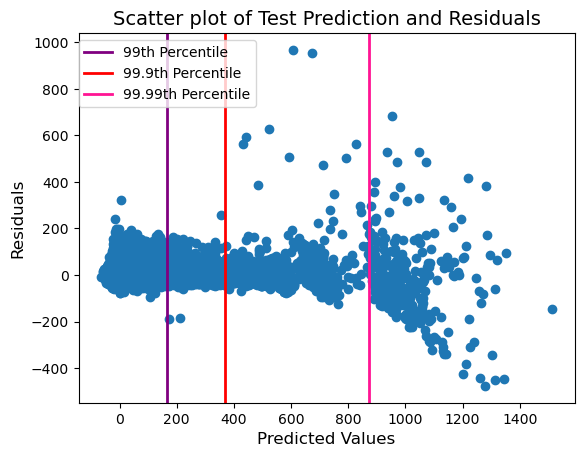

In [28]:
catb_residuals = test_result - catb_test_prediction

plt.scatter(catb_test_prediction, catb_residuals)
plt.axvline(np.percentile(catb_test_prediction, 99), color="purple", linewidth=2, label="99th Percentile")
plt.axvline(np.quantile(catb_test_prediction, 0.999), color="red", linewidth=2, label="99.9th Percentile")
plt.axvline(np.quantile(catb_test_prediction, 0.9999), color="deeppink", linewidth=2, label="99.99th Percentile")

plt.title("Scatter plot of Test Prediction and Residuals", size=14)
plt.xlabel("Predicted Values", size=12)
plt.ylabel("Residuals", size=12)
plt.legend(fontsize=10, loc=(0, 0.8))

plt.show()

Catboost has a similiar Residual variation to the other 2 Gradient Boosting models.

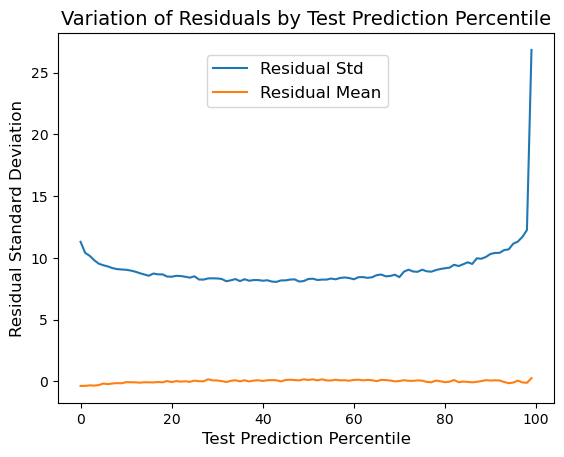

In [29]:
catb_df = pd.DataFrame({"prediction": catb_test_prediction,
                        "residual": catb_residuals})

catb_df["percentile"] = pd.qcut(catb_df["prediction"], q=100, labels=False)

grouped_catb_df = catb_df.groupby("percentile")["residual"].agg(["mean", "std"])

plt.plot(grouped_catb_df.index, grouped_catb_df["std"], label="Residual Std")
plt.plot(grouped_catb_df.index, grouped_catb_df["mean"], label="Residual Mean")

plt.title("Variation of Residuals by Test Prediction Percentile", size=14)
plt.xlabel("Test Prediction Percentile", size=12)
plt.ylabel("Residual Standard Deviation", size=12)
plt.legend(fontsize=12, loc=(0.3,0.8))

plt.show()

There does not appear to be a bias based on the size of the Test Prediction, and the Residual variation by percentile is similiar, though more heterostadistic than LightGBM.

In [30]:
# Feature Importance.
catb_importance_df = (pd.DataFrame({"Gain Importance": best_catb.get_feature_importance(type="PredictionValuesChange")},
                                  index=cat_cols + num_cols)
                      .sort_values(by="Gain Importance", ascending=False))

catb_importance_df/catb_importance_df.sum()

,Gain Importance
DEPARTURE_DELAY,0.500883
TAXI_OUT,0.100854
ORIGIN_AIRPORT,0.069326
AIRLINE,0.057599
DISTANCE,0.053990
DESTINATION_AIRPORT,0.039865
MONTH,0.034646
SCHEDULED_DEPARTURE_HOURS_MINUTES,0.030729
OG_AIRPORT_AIRLINE,0.027675
SCHEDULED_ARRIVAL_HOURS_MINUTES,0.025239


Whilst it appears that CatBoost prioritises Departure Delay significantly less than both other Gradient Boosting models, due to the different way that CatBoost calculates its feature importance, we can't compare the direct figures.

We can note, however, that unlike LightGBM it prioritises Airline over the Origin Airport-Airline Combination, and unlike both other Gradient Boosting models, it does not prioritise the Day of the month.

***
# Model Analysis

In [31]:
model_comparison.sort_values(by="Test_r2_score", ascending=False)

,Test_r2_score,Train_r2_score,Test_RMSE_score,Test_MAE_score
Model,,,,
LightGBM,0.954277,0.971709,8.391894,5.691100
CatBoost,0.943521,0.954988,9.326881,6.326891
LinearRegression,0.939136,0.939362,9.682145,6.853544
XGBoost,0.900357,0.922401,12.388402,6.302924


The best performing model is LightGBM, based off of r2 score.  Whilst it does slightly overfit, it does not do so by an aggregious amount.  Based off of previous iterations of my model, there is significant room for regularisation measures without significantly decreasing the r2 score.  It has overfit, for the same reason why it is so effective, because it is able to find complicated patterns in the data, and some of these patterns

CatBoost is the 2nd best model followed by LinearRegression.

XGBoost is the worst performing model by r2 (and RMSE), and like LightGBM also overfits, but has a significant amount of regularisation already.

However, its MAE is the 2nd best.  XGBoost is generally good, but particularly bad at predicting very large values (as we saw in its model analysis).

In [32]:
pd.Series([linear_residuals.std(),
           xgb_residuals.std(),
           lgbm_residuals.std(),
           catb_residuals.std()],
          index=models,
          name="Residual Std")\
    .sort_values()

LightGBM             8.391894
CatBoost             9.326883
LinearRegression     9.682146
XGBoost             12.360403
Name: Residual Std, dtype: float64

When we look at the Standard Deviation of Residuals, it tells the same story as the r2 scores.

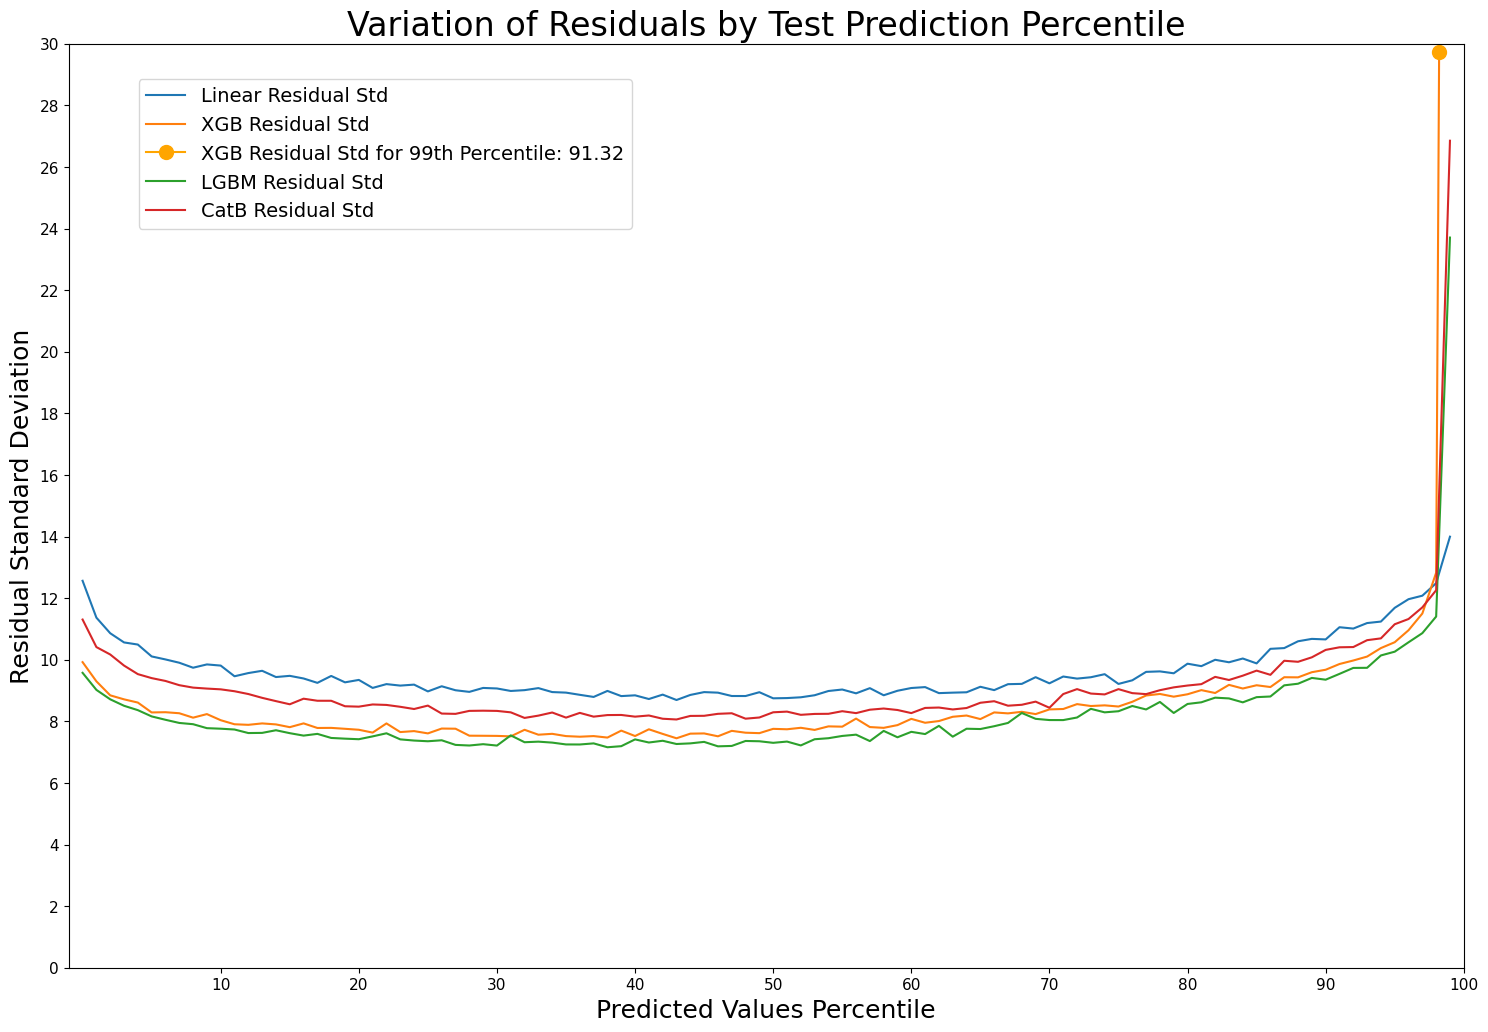

In [33]:
plt.figure(figsize=(18,12))
plt.plot(grouped_linear_df.index, grouped_linear_df["std"], label="Linear Residual Std")
plt.plot(grouped_xgb_df.index, grouped_xgb_df["std"], label="XGB Residual Std")
plt.plot(98.2, 29.73, color="orange", marker="o", markersize=10, label=f"XGB Residual Std for 99th Percentile: {grouped_xgb_df.loc[99, 'std']:.2f}")
plt.plot(grouped_lgbm_df.index, grouped_lgbm_df["std"], label="LGBM Residual Std")
plt.plot(grouped_catb_df.index, grouped_catb_df["std"], label="CatB Residual Std")

plt.title("Variation of Residuals by Test Prediction Percentile", size=24)
plt.xlabel("Predicted Values Percentile", size=18)
plt.xticks(range(10,101,10), size=11)
plt.xlim(-1,100)
plt.ylabel("Residual Standard Deviation", size=18)
plt.yticks(range(0, 31, 2), size=11)
plt.ylim(0, 30)
plt.legend(fontsize=14, loc=(0.05,0.8))

plt.show()

For all percentiles, other than the 99th, the best performing model is LightGBM.  Among the 99th percentile of Predicted Values, Linear Regression is the best predictive model.

XGBoost's poor r2 score clearly comes from its poor handling of the 99th percentile of Predicted Values.

CatBoost, despite being the 2nd best model in terms of r2 score, has a clearly higher Residual Std for every percentile of the Predicted Values.

In [34]:
pd.Series([grouped_linear_df["mean"].std(),
           grouped_xgb_df["mean"].std(),
           grouped_lgbm_df["mean"].std(),
           grouped_catb_df["mean"].std()],
          index=models,
          name="Std of Bias Across Percentiles")\
    .sort_values()

CatBoost            0.119078
LightGBM            0.220669
XGBoost             0.251751
LinearRegression    0.399389
Name: Std of Bias Across Percentiles, dtype: float64

When we look at the bias of models, it is LinearRegression that has the highest bias, and CatBoost with the least.

In [35]:
lgbm_catb_df = pd.concat([test_data[["AIRLINE", "DAY"]].rename({"AIRLINE":"IATA_CODE"}, axis=1),
                          lgbm_residuals.rename("LGBM Residuals"),
                          catb_residuals.rename("CatB Residuals"),
                          test_result],
                         axis=1)

airlines_df = pd.read_csv("data/airlines.csv")
lgbm_catb_df = pd.merge(lgbm_catb_df, airlines_df, on="IATA_CODE")

grouped_lgbm_catb_df = (lgbm_catb_df.groupby("AIRLINE").agg({"LGBM Residuals":"std",
                                                             "CatB Residuals":"std",
                                                             "ARRIVAL_DELAY":"std",
                                                             "DAY":"count"})
                        .rename({"DAY":"Number of Flights"}, axis=1)
                        .sort_values(by="Number of Flights", ascending=False))
grouped_lgbm_catb_df.sort_values("ARRIVAL_DELAY")

,LGBM Residuals,CatB Residuals,ARRIVAL_DELAY,Number of Flights
AIRLINE,,,,
Hawaiian Airlines Inc.,7.321925,8.237503,26.352763,37872
Alaska Airlines Inc.,8.915049,9.680248,28.327781,85940
US Airways Inc.,8.564414,9.866738,32.239274,96968
Southwest Airlines Co.,6.971667,7.828084,32.878050,622917
Virgin America,9.167833,10.754302,36.163508,30572
Delta Air Lines Inc.,8.109308,9.096275,38.698344,434784
Skywest Airlines Inc.,7.274235,7.766961,39.255667,287981
Atlantic Southeast Airlines,7.602292,8.170928,40.458290,277130
JetBlue Airways,8.848947,10.151483,41.398779,130706


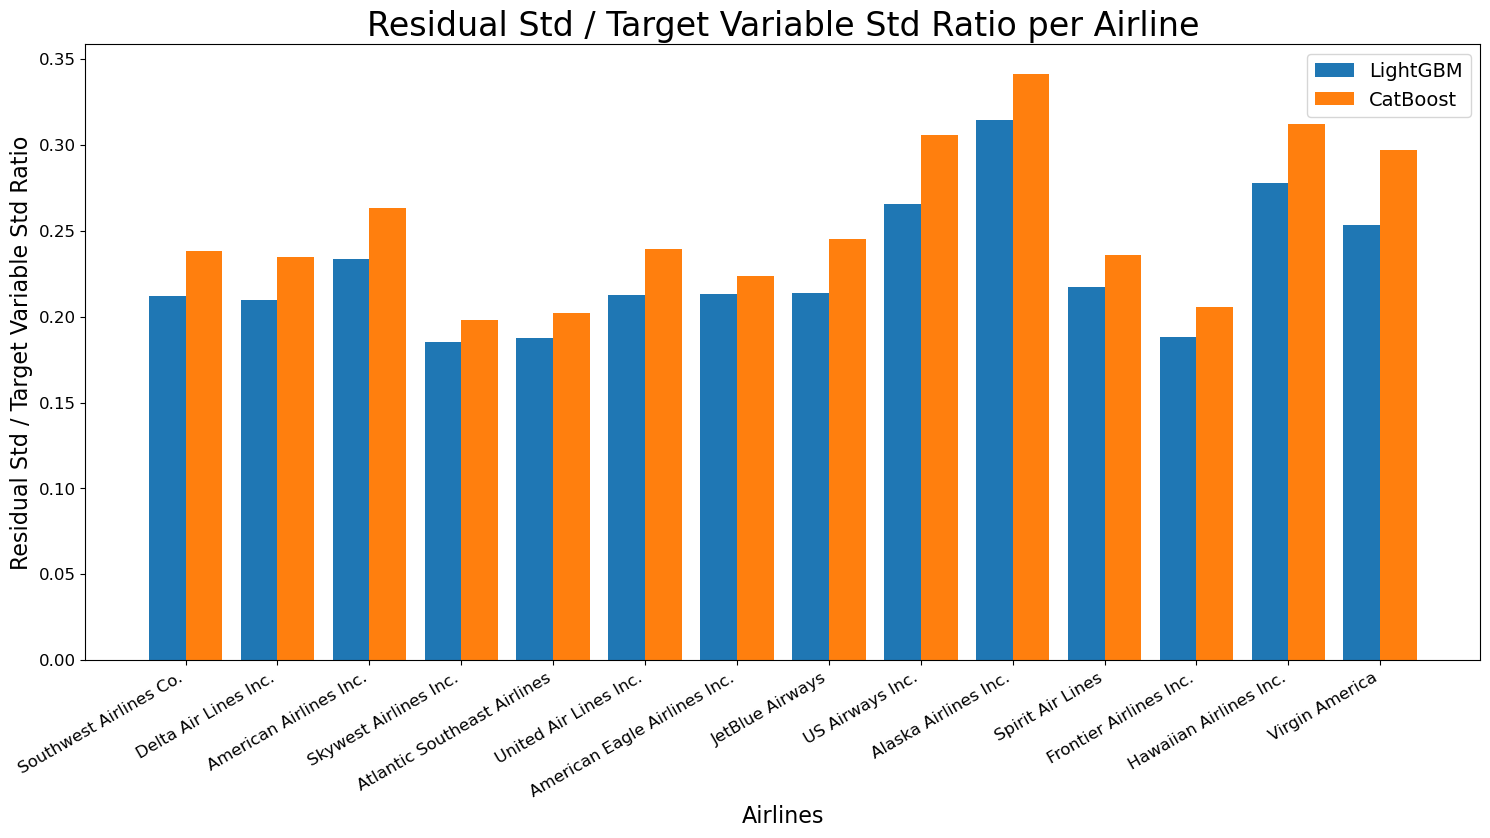

In [36]:
lgbm_ratio = grouped_lgbm_catb_df["LGBM Residuals"]/grouped_lgbm_catb_df["ARRIVAL_DELAY"]
catb_ratio = grouped_lgbm_catb_df["CatB Residuals"]/grouped_lgbm_catb_df["ARRIVAL_DELAY"]

width = 0.4
x_values = np.arange(len(grouped_lgbm_catb_df))
plt.figure(figsize=(18,8))

plt.bar(x_values - width/2, lgbm_ratio, width=width, label="LightGBM")
plt.bar(x_values + width/2, catb_ratio, width=width, label="CatBoost")

plt.title("Residual Std / Target Variable Std Ratio per Airline", size=24)
plt.xticks(x_values, labels=grouped_lgbm_catb_df.index, rotation=30, ha="right", size=12)
plt.xlabel("Airlines", size=16)
plt.yticks(size=12)
plt.ylabel("Residual Std / Target Variable Std Ratio", size=16)
plt.legend(fontsize=14)

plt.show()

The airlines are ordered, left to right, by the number of flights in the Test dataset.

The 2 airlines with the lowest Standard Deviation in their Arrival Delay, Alaska and Hawaiian, are the 2 airlines with the largest ratios, and therefore have the least amount of variation explained by the model.  I suspect the variation that the model is unable to explain is irreducible noise and is just more apparent when there is less overall variation to explain.

Just looking at the 2 best performing models, for every single airline, LightGBM performs better than CatBoost, although the extent varies per Airline.

In [37]:
lgbm_importance_df/lgbm_importance_df.sum()

,Gain Importance,Split Importance
DEPARTURE_DELAY,0.916425,0.057192
TAXI_OUT,0.035470,0.038993
OG_AIRPORT_AIRLINE,0.017218,0.224077
DESTINATION_AIRPORT,0.006430,0.111175
ORIGIN_AIRPORT,0.005724,0.036422
DAY,0.003919,0.134261
SCHEDULED_ARRIVAL_MINUTE_IN_DESTINATION_TIMEZONE,0.003040,0.137994
DISTANCE,0.002655,0.042996
MONTH,0.002632,0.058019
AIRLINE,0.001635,0.003488


Finally, if we look again at the feature importance of the best model, LightGBM, we can see its heavy reliance on the Departure Delay feature and that the most important categorical feature is the Origin Airport-Airline Combination feature.

***
# Project Evaluation

Overall, the project has been a success.  I successfully cleaned the data and found key insights in my exploratory data analysis that have real-world implications, from finding the airline routes with the least delays, the airport with the most delays, and identifying patterns of flying from different regions of the United States.

For the Predictions, the Gradient Boosting models performing better than LinearRegression shows that learning from the complicated interactions between the features reduces the amount of error in the prediction of Arrival Delays.

For the predictions however, there are a few practical problems:

First, the data used is only from 2015.  This means that if there was a hurricane in September, that the model will be trained on that particular hurricane but there is no guarantee that there will be a hurricane in subsequent Septembers.  The model's strong predictive accuracy could be because it is overfitting to anomalies in the data.  In order to effectively predict flights that have not yet occurred, I would need several more years worth of data.  I would also need a more computational power to run ML algorithms on larger datasets.

Second, the predictions are focused on flights after they take off.  Further work could be undertaken to predict flights before they take off (without using Taxi Out or Departure Delay).  This limits the effectiveness of the ML models because they could only be used once a flight is in the air to assist in finding the time of arrival rather than in informing what flights to take in the first place.  That is currently only achieved by the exploratory data analysis.

### Real-Life Applications
- Cab companies being able to predict, to a higher accuracy, the arrival delay of arriving planes so that they can send their drivers at the optimal time.
- Airlines and airports being able to predict the length of upcoming delays in their flights which would increase the importance
- Individuals using the data exploration to see which airlines, airports, and airline routes to avoid.
-
### Future Model Development
- Using more years of flight data.
- More computational power to use the extra data and to apply a larger grid search.
- Editing the model so that it can predict flight delays in real time and creating an interface to input data so that users can utilise the model's predictive capabilities.